# Preparing a Ground Truth Dataset for Localization

This notebook shows how the ground truth recordings are prepared for the paper: *Scalable Spike Source Localization in Extracellular Recordings using Amortized Variational Inference*.

For the data preparation, we perform the data augmentation described in the original manuscript. This data augmentation introduces "virtual" channels which exist outside of the MEA, in addition to the real, recording channels. We extract all "detected" events from a patch of channels near the soma of the firing neuron and then center the extracted data on the channel with the largest detected spike. This provides a realistic dataset for evaluating the performance our localization method.

We designed this notebook to be compatible with any ground truth dataset generated by [MEArec](https://github.com/alejoe91/MEArec), the extracellular dataset simulator we used for all of our simulated data analysis.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import quantities as pq

import matplotlib.pyplot as plt
import matplotlib as mpl
np.set_printoptions(suppress=True)
import math
import itertools
import pickle
import h5py
from collections import namedtuple
from collections import defaultdict
import ast
import spikeextractors as se
import spiketoolkit as st
import MEArec as mr
from utility_functions.data_augmentation_functions import getPeakEvent, getPeakEvents, getChannelSquare

import matplotlib as mpl
mpl.rc('xtick', labelsize=12) 
mpl.rc('ytick', labelsize=12) 
mpl.rcParams.update({'font.size': 12})

import urllib
from urllib.request import urlretrieve
import os
from zipfile import ZipFile

11:44:01 [I] klustakwik KlustaKwik2 version 0.2.6
/afs/inf.ed.ac.uk/user/s17/s1727843/miniconda3/envs/spikeinterface/lib/python3.7/site-packages/networkx-2.2-py3.7.egg/networkx/classes/reportviews.py:95: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping, Set, Iterable


Here you can download an example MEArec dataset that is 4.2gb. This example dataset is used throughout these notebooks

In [2]:
#Example MEArec dataset to be downloaded (4.2gb)
file_url = 'https://www.dropbox.com/s/1jolgsw5kgxmsd5/recordings_300_SqMEA-10-15um_minamp0_60s_10uV_far-neurons_bpf_25-03-2019.h5?dl=1'
file_name = 'recordings/recordings_300_SqMEA-10-15um_minamp0_60s_10uV_far-neurons_bpf_25-03-2019.h5'

urllib.request.urlretrieve(file_url, file_name)

('recordings/recordings_300_SqMEA-10-15um_minamp0_60s_10uV_far-neurons_bpf_25-03-2019.h5',
 <http.client.HTTPMessage at 0x7f72f10d4c50>)

Here, the path to the MEArec recording and recording name are provided

In [3]:
recording_directory = 'recordings/'#'/disk/scratch/cole/recordings/'
recording_name = 'recordings_300_SqMEA-10-15um_minamp0_60s_10uV_far-neurons_bpf_25-03-2019.h5'
save_directory = 'model_data/'

#
width = 45 # The distance from the channel with the largest amplitude spike for which channels are included in the constructed data (microns).
spike_jitter = 5 # The number of frames used to align the extracted waveforms. We search within +-5 frames of the ground truth spike time to find the true peak.
amp_jitter = 10 # The amplitude jitter hyperparameter (described in the manuscript)
save = True # Save the dataset to the save_directory if True

file_name = recording_directory + recording_name
print(file_name)
recgen = mr.load_recordings(recording_directory + recording_name)
channel_positions = recgen.channel_positions
soma_positions = [st.annotations['soma_position'] for st in recgen.spiketrains]

recordings/recordings_300_SqMEA-10-15um_minamp0_60s_10uV_far-neurons_bpf_25-03-2019.h5


We now pad the electrode positions with "virtual" channels that lie outside the bounds of the MEA

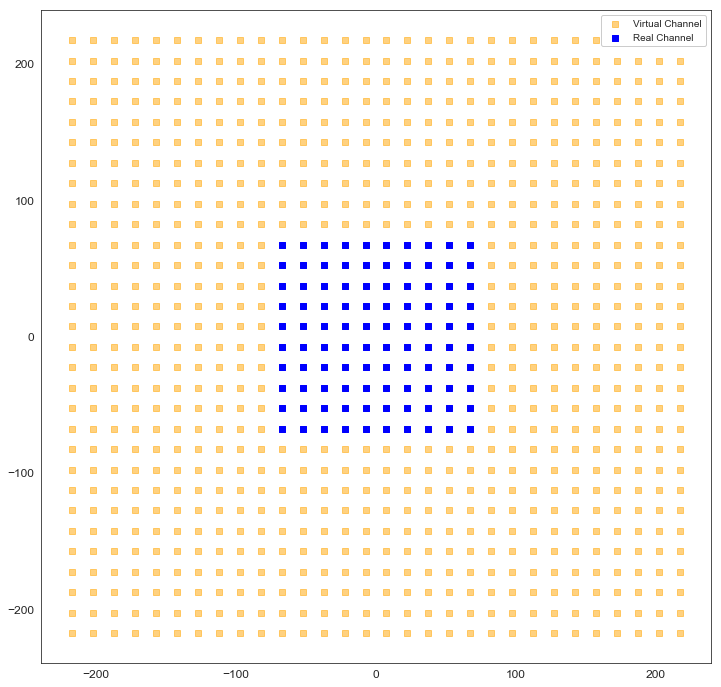

In [4]:
sorted_widths = np.unique(np.sort(channel_positions[:,1]))
buffer_height = sorted_widths[-1] + (-sorted_widths[0]) + (sorted_widths[-1] - sorted_widths[-2])
sorted_heights = np.unique(np.sort(channel_positions[:,2]))
buffer_width = sorted_heights[-1] + (-sorted_heights[0]) + (sorted_heights[-1] - sorted_heights[-2])

padded_channel_list = list(channel_positions)
for i in range(-1, 2):
    for j in range(-1, 2):
        if((i,j) != (0,0)):
            buffer_channel_y = channel_positions[:,1] + buffer_height*i
            buffer_channel_z = channel_positions[:,2] + buffer_width*j
            channel_positions_copy = np.copy(channel_positions)
            channel_positions_copy[:,1] += buffer_height*i
            channel_positions_copy[:,2] += buffer_width*j
            padded_channel_list = padded_channel_list + list(channel_positions_copy)

padded_channel_positions = np.asarray(padded_channel_list)

plt.figure(figsize=(12, 12))
plt.scatter(padded_channel_positions[:,1], padded_channel_positions[:,2], color='orange', marker='s', alpha=.5, label='Virtual Channel')
plt.scatter(channel_positions[:,1], channel_positions[:,2], color='blue', marker='s', label='Real Channel')
plt.legend(fancybox=True, framealpha=1);

Now, we extract all the waveforms for each event in the recording and compute the closest channels to each neuron for later use

In [5]:
waveforms_all = []
num_neurons = len(soma_positions)
for neuron in range(num_neurons):  
    waveforms = recgen.spiketrains[neuron].waveforms
    waveforms_all.append(waveforms)

closest_channels = []
for neuron in range(num_neurons):
    dists = []
    channels = []
    for channel in range(channel_positions.shape[0]):
        dist = np.linalg.norm(soma_positions[neuron] -  channel_positions[channel])
        dists.append(dist)
        channels.append(channel)
    closest_channels.append(np.asarray(channels)[np.argsort(dists)])

Finally, we construct and save the augmented data in a format that can be used for our localization method. We also store the ground truth for later evaluation.

In [6]:
amps_list = []
loc_list = []
neuron_pos_list = []
center_pos_list = []
neuron_list = []
waveforms_list_list = []
overlap_list = []
min_channel_list = []
spike_time_list = []
spike_id_list = []
spike_id = 0
for unit, waveforms_unit in enumerate(waveforms_all):
    for event_idx, waveforms in enumerate(waveforms_unit):
        #Extract the overlap information about the event: 'NO', 'O', 'SO' as described in the MEArec documentation
        overlap_event = recgen.spiketrains[unit].annotations['overlap'][event_idx]
        dists = []
        amps = []
        locations = []
        # Find the frames, channels, and amplitudes are all spikes which have an amplitude within an amp_jitter of the largest spike. 
        # Looks at the 10 channels closest to the neuron. This allows for extracting the correct spikes for each neuron, but is only something we can do with ground truth.
        min_frames, min_channels, min_amps = getPeakEvents(waveforms, closest_channels[unit][:10], amp_jitter=amp_jitter,spike_jitter=spike_jitter)
        for i, min_channel in enumerate(min_channels):
            min_frame = min_frames[i]
            min_amp = min_amps[i]
            
            #Get a group of channels within the given width from the max channel
            square_channel_tuples, center_position = getChannelSquare(min_channel, padded_channel_positions, width=width)
            new_soma_pos = soma_positions[unit] - center_position

            #Construct augmented data dataset with virtual and real channels (take min of each real channel (jitter around peak))
            amps = []
            locations = []
            dists = []
            waveforms_list = []
            #If all waveforms are positive, we discard the event (this happens incredibly rarely in ground truth data and almost never in real data).
            if(min_amp < 0):
                for sct in square_channel_tuples:
                    channel = sct[0]
                    scaled_position = padded_channel_positions[channel] - center_position
                    channel_x = scaled_position[0]
                    channel_y = scaled_position[1]
                    channel_z = scaled_position[2]
                    if(channel < channel_positions.shape[0]):
                        #Real channel
                        observed = 1
                        #Get min peak within the spike jitter around the frame where the true minimum occurred
                        min_peak = np.min(waveforms[channel, min_frame - spike_jitter:min_frame + spike_jitter]) 
                        #Fix positive readings to 0 (don't want dendritic fluctuations in exponential model)
                        peak_reading = min(0, min_peak)
                        waveforms_list.append(waveforms[channel,:])
                    else:
                        #Virtual channel
                        observed = 0
                        #Virtual reading
                        peak_reading = 0
                        waveforms_list.append(np.zeros(len(waveforms[0,:])))
                    #Calculate relative location compared to center position for channel
                    locations.append([channel_x, channel_y, channel_z])
                    #Construct augmented amplitudes for channel
                    amps.append((peak_reading, observed))
                #Model data
                waveforms_list_list.append(waveforms_list)
                amps_list.append(amps)
                loc_list.append(locations)
                center_pos_list.append(list(center_position))
                min_channel_list.append(min_channel)
                spike_time_list.append(int(recgen.spiketrains[unit][event_idx]*32000))
                spike_id_list.append(spike_id)
                #Label data
                neuron_pos_list.append(list(new_soma_pos))
                neuron_list.append(unit)
                overlap_list.append(overlap_event)
            else:
                pass
        spike_id += 1
# ################################################################################## Save augmented data
if(save):
    channel_string = str(width) +"um"
    #Training data
    hf_train = h5py.File(save_directory + 'model_data_'+ channel_string + '_VAE_'+str(amp_jitter)+'_amp_jitter_' + recording_name, 'w')
    hf_train.create_dataset('amps_list', data=amps_list)
    hf_train.create_dataset('channel_loc_list', data=loc_list)
    hf_train.create_dataset('waveforms_list', data=waveforms_list_list)
    hf_train.create_dataset('center_loc_list', data=center_pos_list)
    hf_train.create_dataset('min_channel_list', data=min_channel_list)
    hf_train.create_dataset('spike_time_list', data=spike_time_list)
    hf_train.create_dataset('spike_id_list', data=spike_id_list)
    hf_train.close()

    #Training Labels
    hf_label = h5py.File(save_directory + 'label_data_' + channel_string + '_VAE_'+str(amp_jitter)+'_amp_jitter_' + recording_name, 'w')
    hf_label.create_dataset('neuron_loc_list', data=neuron_pos_list)
    hf_label.create_dataset('neuron_list', data=neuron_list)
    overlap_list = [a.encode('utf8') for a in overlap_list]
    hf_label.create_dataset('overlap_list', data=overlap_list)
    hf_label.close()

    print("Save Path: " + save_directory + 'model_data_'+ channel_string + '_VAE_'+str(amp_jitter)+'_amp_jitter_' + recording_name)

Save Path: model_data/model_data_45um_VAE_10_amp_jitter_recordings_300_SqMEA-10-15um_minamp0_60s_10uV_far-neurons_bpf_25-03-2019.h5


Now, we can visualize examples for the augmented dataset to see how the data was prepared.

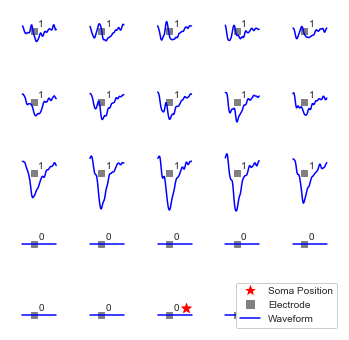

In [20]:
mid_frame = waveforms_all[0].shape[2]//2 # Middle frame of extracted waveform
cutout_start = 19 # Number of frames before peak to plot
cutout_end = 40 # Number of frames after peak to plot
neuron_id = 11 #Neuron ID for the example augmented data to be plotted

neuron_inds = []
for neuron in range(num_neurons):
    neuron_inds.append(np.where(np.asarray(neuron_list)==neuron)[0][0])

event_id = neuron_inds[neuron_id]
amps = amps_list[event_id]
waveforms = np.asarray(waveforms_list_list[event_id])[:,mid_frame-cutout_start:mid_frame+cutout_end]
channel_locs = loc_list[event_id]
neuron_loc = neuron_pos_list[event_id]
neuron = neuron_list[event_id]
center_loc = center_pos_list[event_id]

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

for i in range(len(amps)):
    ax.scatter(channel_locs[i][1] + center_loc[1], channel_locs[i][2] + center_loc[2], s=30, c="grey", marker='s')
    readings = waveforms[i]
    xs = np.linspace(-2.5, 5, waveforms[i].shape[0])
    scaler = .1
    plt.plot(channel_locs[i][1] +  center_loc[1] + xs, channel_locs[i][2] + center_loc[2] + readings*.1, color='blue')
    observed = amps[i][1]
    text = ax.annotate(amps[i][1], (channel_locs[i][1] + center_loc[1] + 1, channel_locs[i][2] + center_loc[2] + 1))
    text.set_fontsize(10)
ax.scatter(neuron_loc[1] + center_loc[1], neuron_loc[2] + center_loc[2], s=100, marker='*', c="red")

ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False); # labels along the bottom edge are off

ax.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,
    left=False,# ticks along the top edge are off
    labelbottom=False,
    labelleft=False); # labels along the bottom edge are off

from matplotlib.lines import Line2D
ax.set_axis_off()
line1 = Line2D(range(1), range(1), color="white", marker='*', markerfacecolor="red", markersize=15)
line2 = Line2D(range(1), range(1), color="white", marker='s', markerfacecolor="grey", markersize=10)
line3 = Line2D(range(1), range(1), color="blue", markerfacecolor="blue", markersize=12)

plt.legend((line1,line2,line3),('Soma Position','Electrode', 'Waveform'),numpoints=1, loc=4, framealpha=1);